In [1]:
import pandas as pd
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
data = pd.read_csv('datasets/mood_dataset_preprocessed.csv')

In [3]:
data.head()

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.game,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel
0,AS14.01,2014-02-26 13:00:00,6.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,17.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
1,AS14.01,2014-02-26 15:00:00,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
2,AS14.01,2014-02-26 18:00:00,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AS14.01,2014-02-26 21:00:00,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,AS14.01,2014-02-27 09:00:00,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0


In [4]:
data.fillna(0.0, inplace=True)

In [5]:
data['time'] = pd.to_datetime(data['time'])

In [6]:
result = data.groupby([data['time'].dt.date, 'id']).size().reset_index(name='count')

In [7]:
result

,time,id,count
0,2014-02-26,AS14.01,4
1,2014-02-27,AS14.01,3
2,2014-03-04,AS14.17,2
3,2014-03-05,AS14.08,3
4,2014-03-05,AS14.17,3
...,...,...,...
1263,2014-06-04,AS14.24,4
1264,2014-06-05,AS14.24,5
1265,2014-06-06,AS14.24,4
1266,2014-06-07,AS14.24,1


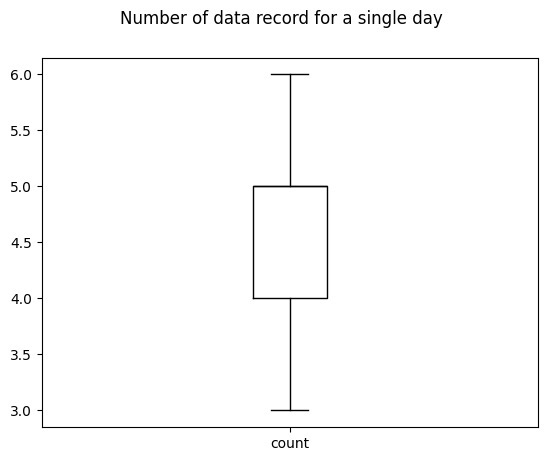

In [8]:
result.boxplot('count', grid=False, showfliers=False, color="black")
plt.suptitle("Number of data record for a single day")
plt.xlabel("")
plt.show()

In [9]:
data["next_mood"] = data.groupby('id')['mood'].shift(-1)

In [10]:
data.head(30)

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel,next_mood
0,AS14.01,2014-02-26 13:00:00,6.0,0.000,0.000,7.0,0.0,0.000000,0.000,0.000,...,0.000,17.0,0.000,0.000,-1.0,0.000000,0.000,0.000,0.000,6.0
1,AS14.01,2014-02-26 15:00:00,6.0,0.000,0.000,0.0,1.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,-1.0,0.000000,0.000,0.000,0.000,6.0
2,AS14.01,2014-02-26 18:00:00,6.0,0.000,0.000,1.0,1.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,0.0,0.000000,0.000,0.000,0.000,7.0
3,AS14.01,2014-02-26 21:00:00,7.0,0.000,0.000,0.0,1.0,0.000000,0.000,0.000,...,0.000,1.0,0.000,0.000,1.0,0.000000,0.000,0.000,0.000,6.0
4,AS14.01,2014-02-27 09:00:00,6.0,0.000,0.000,1.0,0.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,-2.0,0.000000,0.000,0.000,0.000,6.0
5,AS14.01,2014-02-27 12:00:00,6.0,0.000,0.000,0.0,0.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,1.0,0.000000,0.000,0.000,0.000,7.0
6,AS14.01,2014-02-27 15:00:00,7.0,0.000,0.000,0.0,1.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,1.0,0.000000,0.000,0.000,0.000,6.0
7,AS14.01,2014-03-21 09:00:00,6.0,2300.541,11.345,10.0,0.0,4793.343000,350.856,0.000,...,0.000,33.0,496.208,0.000,-1.0,0.238190,302.689,45.173,0.000,6.0
8,AS14.01,2014-03-21 11:00:00,6.0,1794.749,38.160,0.0,0.0,4240.973000,403.980,0.000,...,0.000,0.0,587.566,18.196,0.0,0.065054,18.061,0.000,71.305,7.0
9,AS14.01,2014-03-21 15:00:00,7.0,1488.071,70.860,0.0,1.0,5467.570000,287.389,0.000,...,62.281,4.0,979.241,0.000,1.0,1.931720,154.724,0.000,844.140,6.0


In [11]:
average_moods = data.groupby('id')['mood'].mean()
data['next_mood'] = data.apply(
    lambda row: int(average_moods[row['id']]) if pd.isna(row['next_mood']) else int(row['next_mood']),
    axis=1
)

In [12]:
data.head()

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel,next_mood
0,AS14.01,2014-02-26 13:00:00,6.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,17.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,6
1,AS14.01,2014-02-26 15:00:00,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,6
2,AS14.01,2014-02-26 18:00:00,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
3,AS14.01,2014-02-26 21:00:00,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6
4,AS14.01,2014-02-27 09:00:00,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,6


In [13]:
features = ['mood', 'appCat.communication', 'appCat.other', 'sms',
       'circumplex.valence', 'screen', 'appCat.entertainment',
       'appCat.weather', 'appCat.social', 'appCat.game', 'appCat.office',
       'call', 'appCat.builtin', 'appCat.finance', 'circumplex.arousal',
       'activity', 'appCat.utilities', 'appCat.unknown', 'appCat.travel']
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

In [14]:
data.head()

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel,next_mood
0,AS14.01,2014-02-26 13:00:00,0.555556,0.0,0.0,0.084337,0.6,0.0,0.0,0.0,...,0.0,0.062044,0.7044,0.0,0.4,0.0,0.0,0.0,0.0,6
1,AS14.01,2014-02-26 15:00:00,0.555556,0.0,0.0,0.000000,0.8,0.0,0.0,0.0,...,0.0,0.000000,0.7044,0.0,0.4,0.0,0.0,0.0,0.0,6
2,AS14.01,2014-02-26 18:00:00,0.555556,0.0,0.0,0.012048,0.8,0.0,0.0,0.0,...,0.0,0.000000,0.7044,0.0,0.6,0.0,0.0,0.0,0.0,7
3,AS14.01,2014-02-26 21:00:00,0.666667,0.0,0.0,0.000000,0.8,0.0,0.0,0.0,...,0.0,0.003650,0.7044,0.0,0.8,0.0,0.0,0.0,0.0,6
4,AS14.01,2014-02-27 09:00:00,0.555556,0.0,0.0,0.012048,0.6,0.0,0.0,0.0,...,0.0,0.000000,0.7044,0.0,0.2,0.0,0.0,0.0,0.0,6


In [44]:
len(data)

5641

In [15]:
result = data.groupby([data['time'].dt.date, 'id']).apply(lambda x:  x.drop(columns=['time']).values.tolist(), include_groups=False).reset_index(drop=True)

In [43]:
len(result)

1268

In [16]:
MAX_LEN = 5

In [17]:
predictions = []
results = []

for single_data in result:
    if len(single_data) < MAX_LEN:
        n_fill = MAX_LEN - len(single_data)
        predictions.append(int(single_data[-1][-1]))
        while n_fill:
            single_data.append([0.0]*20)
            n_fill -= 1
    else:
        single_data = single_data[:MAX_LEN]
        predictions.append(int(single_data[-1][-1]))
    
    for single_record in single_data:
        del single_record[-1]
    
    results.append(single_data[:])    

In [18]:
for i in results:
    if len(i) != 5:
        print(len(i))

In [19]:
predictions = [i - 1 for i in predictions]

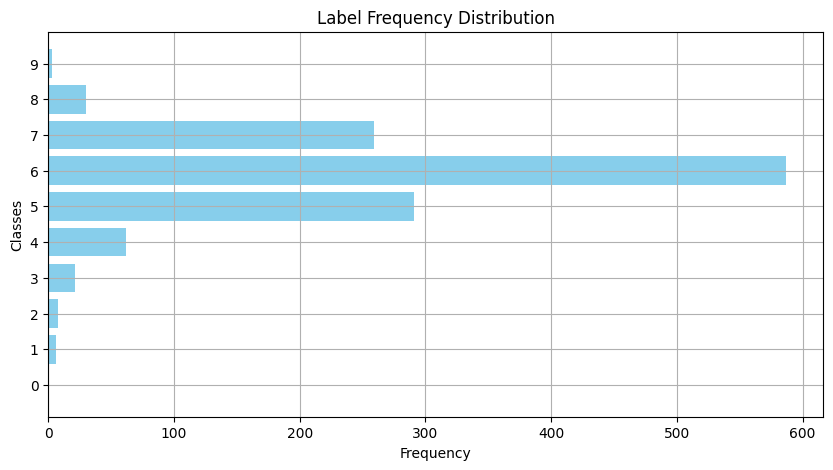

In [20]:
counter = Counter(predictions).most_common()
class_names = []
frequencies = []

for name, count in counter:
    class_names.append(name)
    frequencies.append(count)

plt.figure(figsize=(10, 5))
plt.barh(class_names, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Classes')
plt.yticks(range(10))
plt.title('Label Frequency Distribution')
plt.grid(True)
plt.show()

In [21]:
len(set(predictions))

10

In [22]:
data_tensor = torch.tensor(results, dtype=torch.float32)
labels_tensor = torch.tensor(predictions, dtype=torch.long)

dataset = TensorDataset(data_tensor, labels_tensor)

In [23]:
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

In [24]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [25]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [68]:
class MoodLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MoodLSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output dimension is 10 for 10 classes
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, (_, _) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [69]:
model = MoodLSTMClassifier(input_dim=19, hidden_dim=10, num_layers=1, output_dim=10)

In [70]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class problems
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [71]:
model.train()
loss_result = []
for epoch in range(100):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # No need to squeeze or convert labels
        loss.backward()
        optimizer.step()
        loss_result.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 2.3262500762939453
Epoch 1, Loss: 2.293686866760254
Epoch 1, Loss: 2.314033031463623
Epoch 1, Loss: 2.2975785732269287
Epoch 1, Loss: 2.310148000717163
Epoch 1, Loss: 2.260960102081299
Epoch 1, Loss: 2.2942960262298584
Epoch 1, Loss: 2.2951560020446777
Epoch 1, Loss: 2.294281482696533
Epoch 1, Loss: 2.3144690990448
Epoch 1, Loss: 2.3053066730499268
Epoch 1, Loss: 2.2957682609558105
Epoch 1, Loss: 2.294511556625366
Epoch 1, Loss: 2.2683136463165283
Epoch 1, Loss: 2.2689831256866455
Epoch 1, Loss: 2.289785861968994
Epoch 2, Loss: 2.2711246013641357
Epoch 2, Loss: 2.2529656887054443
Epoch 2, Loss: 2.2578048706054688
Epoch 2, Loss: 2.275829315185547
Epoch 2, Loss: 2.25106143951416
Epoch 2, Loss: 2.241323947906494
Epoch 2, Loss: 2.24275803565979
Epoch 2, Loss: 2.265791177749634
Epoch 2, Loss: 2.2587366104125977
Epoch 2, Loss: 2.245044469833374
Epoch 2, Loss: 2.2628183364868164
Epoch 2, Loss: 2.251054525375366
Epoch 2, Loss: 2.2559125423431396
Epoch 2, Loss: 2.2344448566436768

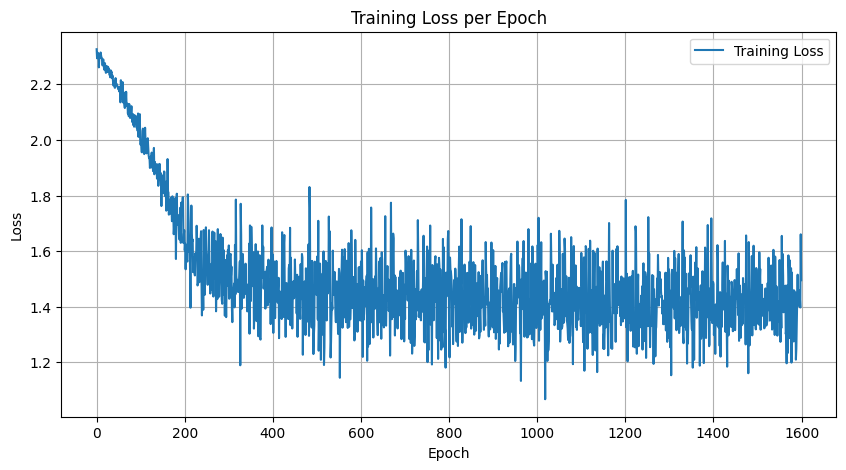

In [72]:
def plot_training_loss(training_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("small_lr_lstm.png")
    plt.show()
plot_training_loss(loss_result)

In [67]:
model.eval()  # Set the model to evaluation mode
all_predictions = [] 
all_labels = []
with torch.no_grad():  # No gradient tracking needed
    correct, total = 0, 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Thresholding at 0.5
        all_predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
    print(f'Accuracy: {100 * correct / total}%')


Accuracy: 46.8503937007874%


In [40]:
def plot_confusion_matrix(y_p, y_t, labels):
    cm =  confusion_matrix(y_t, y_p, normalize='true', labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    #plt.show()
    plt.savefig("lstm-result.png")
    

In [41]:
plot_confusion_matrix(all_predictions, all_labels, [i for i in range(10)])

In [42]:
model.eval()  # Set the model to evaluation mode
all_predictions = [] 
all_labels = []
with torch.no_grad():  # No gradient tracking needed
    correct, total = 0, 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Thresholding at 0.5
        all_predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
    print(f'Accuracy: {100 * correct / total}%')
    
def plot_confusion_matrix(y_p, y_t, labels):
    cm =  confusion_matrix(y_t, y_p, normalize='true', labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    #plt.show()
    plt.savefig("lstm-result-training.png")

plot_confusion_matrix(all_predictions, all_labels, [i for i in range(10)])

Accuracy: 51.87376725838264%


In [33]:
!pip install optuna


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [34]:
import optuna

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        print(f'Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')

def compute_validation_accuracy(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def objective(trial):
    # Define hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_dim = trial.suggest_int('hidden_dim', 20, 50)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)

    model = MoodLSTMClassifier(input_dim=19, hidden_dim=hidden_dim, output_dim=10, num_layers=num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
    return compute_validation_accuracy(model, test_loader)  # Define this function to compute accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print("Best hyperparameters:", study.best_params)

[I 2024-04-19 18:01:16,160] A new study created in memory with name: no-name-0fa34f09-e474-46a8-8c6b-09f241ec15e6
/tmp/ipykernel_29061/1978370737.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-04-19 18:01:16,393] Trial 0 finished with value: 46.45669291338583 and parameters: {'num_layers': 2, 'hidden_dim': 30, 'lr': 0.040221082468579215}. Best is trial 0 with value: 46.45669291338583.


Epoch 1, Validation Loss: 1.42500838637352
Epoch 2, Validation Loss: 1.4050134718418121
Epoch 3, Validation Loss: 1.4140232503414154
Epoch 4, Validation Loss: 1.4076275825500488
Epoch 5, Validation Loss: 1.4062933921813965
Epoch 6, Validation Loss: 1.4025825560092926
Epoch 7, Validation Loss: 1.4194251596927643
Epoch 8, Validation Loss: 1.406197875738144
Epoch 9, Validation Loss: 1.4092023074626923
Epoch 10, Validation Loss: 1.4377805292606354


[I 2024-04-19 18:01:16,547] Trial 1 finished with value: 46.45669291338583 and parameters: {'num_layers': 1, 'hidden_dim': 31, 'lr': 0.004975738960823493}. Best is trial 0 with value: 46.45669291338583.


Epoch 1, Validation Loss: 1.4263383150100708
Epoch 2, Validation Loss: 1.4009965360164642
Epoch 3, Validation Loss: 1.4049737751483917
Epoch 4, Validation Loss: 1.3933616280555725
Epoch 5, Validation Loss: 1.397643893957138
Epoch 6, Validation Loss: 1.3996812105178833
Epoch 7, Validation Loss: 1.396415263414383
Epoch 8, Validation Loss: 1.4061491787433624
Epoch 9, Validation Loss: 1.3951889276504517
Epoch 10, Validation Loss: 1.4015214443206787
Epoch 1, Validation Loss: 1.4360286891460419
Epoch 2, Validation Loss: 1.4197438657283783
Epoch 3, Validation Loss: 1.3923153281211853


[I 2024-04-19 18:01:16,710] Trial 2 finished with value: 46.45669291338583 and parameters: {'num_layers': 1, 'hidden_dim': 47, 'lr': 0.005868197524688559}. Best is trial 0 with value: 46.45669291338583.


Epoch 4, Validation Loss: 1.4003676772117615
Epoch 5, Validation Loss: 1.399015873670578
Epoch 6, Validation Loss: 1.3979965150356293
Epoch 7, Validation Loss: 1.395206779241562
Epoch 8, Validation Loss: 1.3982405960559845
Epoch 9, Validation Loss: 1.3945306837558746
Epoch 10, Validation Loss: 1.3998369872570038
Epoch 1, Validation Loss: 2.096219301223755
Epoch 2, Validation Loss: 1.4916982650756836
Epoch 3, Validation Loss: 1.4128634929656982
Epoch 4, Validation Loss: 1.3950116336345673


[I 2024-04-19 18:01:16,926] Trial 3 finished with value: 46.45669291338583 and parameters: {'num_layers': 2, 'hidden_dim': 35, 'lr': 0.0013450963911510287}. Best is trial 0 with value: 46.45669291338583.


Epoch 5, Validation Loss: 1.3993982374668121
Epoch 6, Validation Loss: 1.3949503004550934
Epoch 7, Validation Loss: 1.39548459649086
Epoch 8, Validation Loss: 1.3947701156139374
Epoch 9, Validation Loss: 1.392331451177597
Epoch 10, Validation Loss: 1.3970969319343567
Epoch 1, Validation Loss: 2.22295880317688
Epoch 2, Validation Loss: 2.1791459918022156
Epoch 3, Validation Loss: 2.126372218132019
Epoch 4, Validation Loss: 2.058619260787964
Epoch 5, Validation Loss: 1.9663257896900177
Epoch 6, Validation Loss: 1.844426453113556


[I 2024-04-19 18:01:17,074] Trial 4 finished with value: 46.45669291338583 and parameters: {'num_layers': 1, 'hidden_dim': 35, 'lr': 0.0002750127413126729}. Best is trial 0 with value: 46.45669291338583.


Epoch 7, Validation Loss: 1.7010409832000732
Epoch 8, Validation Loss: 1.5752640664577484
Epoch 9, Validation Loss: 1.4932808578014374
Epoch 10, Validation Loss: 1.453214317560196
Epoch 1, Validation Loss: 1.4031721353530884
Epoch 2, Validation Loss: 1.412762075662613
Epoch 3, Validation Loss: 1.3956393897533417
Epoch 4, Validation Loss: 1.4002076089382172
Epoch 5, Validation Loss: 1.39972785115242


[I 2024-04-19 18:01:17,347] Trial 5 finished with value: 46.45669291338583 and parameters: {'num_layers': 3, 'hidden_dim': 38, 'lr': 0.006613324809629608}. Best is trial 0 with value: 46.45669291338583.


Epoch 6, Validation Loss: 1.3998315930366516
Epoch 7, Validation Loss: 1.4003298580646515
Epoch 8, Validation Loss: 1.404970109462738
Epoch 9, Validation Loss: 1.3986628651618958
Epoch 10, Validation Loss: 1.410084754228592
Epoch 1, Validation Loss: 1.4353602528572083
Epoch 2, Validation Loss: 1.4029434621334076
Epoch 3, Validation Loss: 1.4003563523292542
Epoch 4, Validation Loss: 1.404258280992508
Epoch 5, Validation Loss: 1.4021980166435242
Epoch 6, Validation Loss: 1.4046671092510223
Epoch 7, Validation Loss: 1.4003584384918213
Epoch 8, Validation Loss: 1.402320235967636
Epoch 9, Validation Loss: 1.3990428745746613


[I 2024-04-19 18:01:17,650] Trial 6 finished with value: 46.45669291338583 and parameters: {'num_layers': 3, 'hidden_dim': 47, 'lr': 0.0029296635591126432}. Best is trial 0 with value: 46.45669291338583.


Epoch 10, Validation Loss: 1.3987955152988434
Epoch 1, Validation Loss: 1.4177412688732147
Epoch 2, Validation Loss: 1.4030635952949524
Epoch 3, Validation Loss: 1.4117830395698547
Epoch 4, Validation Loss: 1.4127115905284882
Epoch 5, Validation Loss: 1.4014475345611572
Epoch 6, Validation Loss: 1.4064399600028992
Epoch 7, Validation Loss: 1.3997157216072083


[I 2024-04-19 18:01:17,933] Trial 7 finished with value: 46.45669291338583 and parameters: {'num_layers': 3, 'hidden_dim': 49, 'lr': 0.010453287254551049}. Best is trial 0 with value: 46.45669291338583.


Epoch 8, Validation Loss: 1.4038424789905548
Epoch 9, Validation Loss: 1.4039745926856995
Epoch 10, Validation Loss: 1.4063934087753296
Epoch 1, Validation Loss: 1.5571945011615753
Epoch 2, Validation Loss: 1.4168026447296143
Epoch 3, Validation Loss: 1.4009664356708527
Epoch 4, Validation Loss: 1.3987774848937988
Epoch 5, Validation Loss: 1.394398719072342


[I 2024-04-19 18:01:18,210] Trial 8 finished with value: 46.45669291338583 and parameters: {'num_layers': 3, 'hidden_dim': 44, 'lr': 0.0019507352281448263}. Best is trial 0 with value: 46.45669291338583.


Epoch 6, Validation Loss: 1.402176707983017
Epoch 7, Validation Loss: 1.3953818082809448
Epoch 8, Validation Loss: 1.3979088962078094
Epoch 9, Validation Loss: 1.398121863603592
Epoch 10, Validation Loss: 1.3990552723407745
Epoch 1, Validation Loss: 1.8767164945602417
Epoch 2, Validation Loss: 1.4303546845912933
Epoch 3, Validation Loss: 1.4013674855232239


[I 2024-04-19 18:01:18,487] Trial 9 finished with value: 46.45669291338583 and parameters: {'num_layers': 3, 'hidden_dim': 39, 'lr': 0.0016544775044395168}. Best is trial 0 with value: 46.45669291338583.


Epoch 4, Validation Loss: 1.3977637887001038
Epoch 5, Validation Loss: 1.3974324464797974
Epoch 6, Validation Loss: 1.3919488787651062
Epoch 7, Validation Loss: 1.3981341421604156
Epoch 8, Validation Loss: 1.3944471180438995
Epoch 9, Validation Loss: 1.3951225578784943
Epoch 10, Validation Loss: 1.398271083831787
Best hyperparameters: {'num_layers': 2, 'hidden_dim': 30, 'lr': 0.040221082468579215}
